In [278]:
import pandas as pd
import numpy as np
from pandas import Series, DataFrame
import matplotlib.pyplot as plt

import scikitplot as skplt

import copy
import datetime

import pycountry

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, make_scorer, confusion_matrix, roc_curve
from sklearn.linear_model import LinearRegression

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

import seaborn as sns

In [2]:
%matplotlib inline

In [3]:
input_file_path = 'data/train.csv'
df_initial = pd.read_csv(input_file_path)

In [4]:
def rename_columns(df):    
    names_mapping = {}
    for col in df.columns:
        names_mapping[col] = col.replace(' ', '_')
    return df.rename_axis(names_mapping, axis='columns')

In [5]:
school_level_mapping = {
    'kindergarten': 0,
    'primary 1 through 4': 2,
    'primary school': 4,
    'secondary-5 through 6':6,
    'secondary-7 through 8': 8,    
    'secondary-9': 9,
    '10th': 10,
    'secondary 11': 11,
    'secondary': 12,
    'secondary 12': 12,
    'basic vocational': 14,
    'entry level college': 14,
    'advanced vocational': 15,
    'college graduate': 16,
    'some post graduate': 18,
    'advanced post graduate': 20,  
}

job_type_map = {
    'private': 'private',
    'unknown': 'other',
    'local-gov': 'gov',
    'state-gov': 'gov',
    'self-emp-not-inc': 'self-emp',
    'federal-gov': 'gov',
    'self-emp-inc': 'self-emp',
    'without-pay': 'other',
    'never-worked': 'other'
}

In [138]:
def drop_variables(df_input, variables_to_drop):
    df = copy.deepcopy(df_input)
    for variable in variables_to_drop:
        df = df.drop(variable, axis=1)
    return df


def group_spouses(record):
    return ("has spouse" if record in ('has husband', 'has wife') else record)


def years_old(df):
    return (datetime.datetime.now().date() - pd.to_datetime(df.birth_date)).dt.days/365


def convert_school_level(val):
    return school_level_mapping[val]


def binarize_interest_earned(df):
    return df.interest_earned >0


def is_immigrant(df):
    return df.country_of_origin == 'u.s.'


def group_job_types(val):
    return job_type_map[val]


def is_white(df):
    return df.ethnicity == 'white and privileged'


def is_currently_single(df):
    return (
        (df.domestic_status ==  'single') | 
        (df.domestic_status ==   'd') | 
        (df.domestic_status ==   'spouse passed')
    )

In [154]:
def pipeline(df_in, **kwargs):
    df = copy.deepcopy(df_in)
    df = rename_columns(df)
    df = drop_variables(df, ['id', 'gender', 'earned_dividends'])
    df['age'] = years_old(df)    
    df = drop_variables(df, ['birth_date'])
    df['domestic_relationship_type'] = df.domestic_relationship_type.apply(group_spouses)
    
    if kwargs.get('dummy_all',False):
        print("Converting to dummy")
        columns_to_dummy = [
            'job_type',
            'domestic_status',
            'profession',
            'domestic_relationship_type',
            'ethnicity',
        ]
        for col in columns_to_dummy:
            df = pd.get_dummies(df, prefix=col, columns=[col], prefix_sep='.')           
        # df = drop_variables(df, columns_to_dummy)
        
    else:
        df['has_earned_interest'] = binarize_interest_earned(df)
        df['job_type_grouped'] = df.job_type.apply(group_job_types)
        df = pd.get_dummies(df, prefix='job_type', columns=['job_type_grouped'])    
        df['is_currently_single'] = is_currently_single(df)
        df['is_white'] = is_white(df)    
        df = drop_variables(df, ['interest_earned', 'job_type', 'domestic_status', 'domestic_relationship_type', 'ethnicity', 'profession'])
    df['school_years'] = df.school_level.apply(convert_school_level)   
    df['is_immigrant'] = is_immigrant(df)
    df = drop_variables(df, ['school_level', 'country_of_origin'])
    return df

In [155]:
def split_df(df):
    X = df.drop('target', axis=1)
    y = df.target
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3)
    return X_train, X_test, y_train, y_test


def test_classifier(X_train, y_train, Model, score_function, params):
    clf = Model(** params)
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring= score_function)
    print(scores)
    print("%s +- %s" % (scores.mean(), scores.std()))
    return clf.fit(X_train, y_train)


def full_pipeline(df, Model, scoring_function, model_params, pipeline_params):
    df = pipeline(df, **pipeline_params)
    X_train, X_test, y_train, y_test = split_df(df)
    clf = test_classifier(X_train, y_train, Model, scoring_function, model_params)    
    features = X_train.columns
    return clf, features

In [42]:
best_model_params = {
    'RandomForestClassifier':{
        'class_weight': {0:0.9, 1:0.1}
    }    
}

In [156]:
c1, features  =  full_pipeline(df_initial, RandomForestClassifier, make_scorer(roc_auc_score), best_params, {'dummy_all':True})
c2, features = full_pipeline(df_initial, RandomForestClassifier, make_scorer(roc_auc_score), best_params, {'dummy_all':False})

Converting to dummy
[ 0.70935673  0.69052339  0.70487257  0.71251662  0.6683478 ]
0.697123419461 +- 0.0162373051261
[ 0.62916065  0.64540084  0.67234645  0.66488433  0.62630099]
0.647618652311 +- 0.0184912236866


In [158]:
c1, features  =  full_pipeline(df_initial, LinearRegression, make_scorer(roc_auc_score), {'normalize':True}, {'dummy_all':True})
# c2, features = full_pipeline(df_initial, LinearRegression, make_scorer(roc_auc_score), {'normalize':True}, {'dummy_all':False})

Converting to dummy
[ 0.90811129  0.90381745  0.89924999  0.89859954  0.92826758]
0.90760916848 +- 0.0108852965301


In [152]:
features = [u'interest_earned', u'monthly_work', u'age',
       u'job_type.federal-gov', u'job_type.local-gov',
       u'job_type.never-worked', u'job_type.private', u'job_type.self-emp-inc',
       u'job_type.self-emp-not-inc', u'job_type.state-gov',
       u'job_type.unknown', u'job_type.without-pay', u'domestic_status.d',
       u'domestic_status.divorce pending', u'domestic_status.married 1',
       u'domestic_status.married 2', u'domestic_status.married not together',
       u'domestic_status.single', u'domestic_status.spouse passed',
       u'profession.C-level', u'profession.agriculture',
       u'profession.defense contractor', u'profession.estate employee',
       u'profession.household labor', u'profession.mechanic',
       u'profession.other', u'profession.sales', u'profession.secretarial',
       u'profession.specialist technician', u'profession.technology support',
       u'profession.trucking', u'profession.unknown', u'profession.vocational',
       u'domestic_relationship_type.has husband',
       u'domestic_relationship_type.has wife',
       u'domestic_relationship_type.living with child',
       u'domestic_relationship_type.living with extende family',
       u'domestic_relationship_type.never married',
       u'domestic_relationship_type.not living with family',
       u'ethnicity.afro american', u'ethnicity.american indian',
       u'ethnicity.asian', u'ethnicity.other',
       u'ethnicity.white and privileged', u'school_years', u'is_immigrant']

In [150]:
features.pop(3)

u'job_type.federal-gov'

In [159]:
lr_features_importances = pd.Series(c1.coef_, index=features)

In [162]:
lr_features_importances

interest_earned                                         -6.093479e-05
monthly_work                                            -3.363701e-04
age                                                     -1.317583e-03
job_type.federal-gov                                    -7.682708e+12
job_type.local-gov                                      -7.682708e+12
job_type.never-worked                                   -1.916275e+14
job_type.private                                        -7.682708e+12
job_type.self-emp-inc                                   -7.682708e+12
job_type.self-emp-not-inc                               -7.682708e+12
job_type.state-gov                                      -7.682708e+12
job_type.unknown                                        -1.122562e+13
job_type.without-pay                                    -7.682708e+12
domestic_status.d                                       -5.692146e+11
domestic_status.divorce pending                         -5.692146e+11
domestic_status.marr

So, we are considering the absolute value of feature importances. Because the bigger the absolute value, the higher the influence (negative or positive) the feature has on the prediction.

Keep only domestic_status.spouse passed

We are now going to select the most relevant features using a chi2 test

First, replace has_husband and has_wife by has_spouse.

In [204]:
def filter_relevant_features(df, pipeline_params, Model, scoring_function, model_params):
    df = pipeline(df, **pipeline_params)
    X_train, X_test, y_train, y_test = split_df(df)
    k_best = SelectKBest(chi2, k=15)
    X_new = k_best.fit_transform(X_train, y_train)
    test_classifier(X_new, y_train, Model, scoring_function, model_params)    
    return X_new, k_best

In [205]:
res, best_res = filter_relevant_features(df_initial, {'dummy_all':True},  LinearRegression, make_scorer(roc_auc_score), {'normalize': True})

Converting to dummy
[ 0.89305039  0.901171    0.92004509  0.88916016  0.92356615]
0.905398558157 +- 0.0139901208154


In [211]:
pd.Series(best_res.scores_, index = features).sort_values(ascending=False).head(18)

interest_earned                                      246629.600438
domestic_relationship_type.has spouse                  1113.697406
monthly_work                                           1103.971328
domestic_status.married 2                              1089.557729
age                                                     365.160734
profession.specialist technician                        132.704748
domestic_status.single                                  116.332194
domestic_relationship_type.living with child             90.788028
profession.C-level                                       87.837565
school_years                                             82.920289
domestic_relationship_type.never married                 68.286139
profession.other                                         56.421023
job_type.self-emp-inc                                    35.975494
domestic_status.d                                        29.851706
domestic_relationship_type.not living with family        28.35

# Second Iteration

* Merge has spouse with married 1 and 2
* Extract is_single
* Exract living_with_children
* Extract *C-level* and *specialist technician*
* Extract *never married*
* Extract *is self emp*
* Extract *d*
* Extract *not living with family*

In [221]:
def pipeline_2(df_in, **kwargs):
    df = copy.deepcopy(df_in)
    df = rename_columns(df)
    df = drop_variables(df, ['id', 'gender', 'earned_dividends', 'country_of_origin', 'ethnicity'])
    
    # Get age
    df['age'] = years_old(df)    
    df = drop_variables(df, ['birth_date'])
    
    # Convert school level in years
    df['school_years'] = df.school_level.apply(convert_school_level) 
    df = drop_variables(df, ['school_level'])
    
    # Group spouses and extract relevant domestic relationship types
    df['domestic_relationship_type'] = df.domestic_relationship_type.apply(group_spouses)
    df['domestic_relationship_type'] = df.domestic_relationship_type.apply(extract_relevant_domestic_relationship_types)
    df = pd.get_dummies(df, prefix='domestic_relationship_type', columns=['domestic_relationship_type'], prefix_sep='.')  
    
    # Extract relevant professions
    df['profession'] = df.profession.apply(extract_relevant_professions)
    df = pd.get_dummies(df, prefix='profession', columns=['profession'], prefix_sep='.')  
    
    # Extrct relevant job types
    df['job_type'] = df.job_type.apply(extract_relevant_job_types)
    df = pd.get_dummies(df, prefix='job_type', columns=['job_type'], prefix_sep='.')      
        
    # Extract relevant domestic status
    df['domestic_status'] = df.domestic_status.apply(extract_relevant_domestic_status)
    df = pd.get_dummies(df, prefix='domestic_status', columns=['domestic_status'], prefix_sep='.')      
     
    return df

In [215]:
def extract_relevant_professions(profession):
    return profession if profession in ('C-level', 'specialist technician') else 'other'


def extract_relevant_job_types(job_type):
    return job_type if job_type in ('self-emp-inc', 'self-emp-not-inc') else 'other'


def extract_relevant_domestic_status(domestic_status):
    return domestic_status if domestic_status in ('married 2', 'single', 'd', 'divorce pending') else 'other'


def extract_relevant_domestic_relationship_types(domestic_relationship_type):
    return domestic_relationship_type if domestic_relationship_type in ('has spouse', 'living with child', 'never married', 'not living with family') else 'other'

In [217]:
def full_pipeline_2(df, Model, scoring_function, model_params, pipeline_params):
    df = pipeline_2(df, **pipeline_params)
    X_train, X_test, y_train, y_test = split_df(df)
    clf = test_classifier(X_train, y_train, Model, scoring_function, model_params)    
    features = X_train.columns
    return clf, features

In [222]:
c3, features  =  full_pipeline_2(df_initial, LinearRegression, make_scorer(roc_auc_score), {'normalize':True}, {'dummy_all':True})


[ 0.89419497  0.90368808  0.90344967  0.9108496   0.89882613]
0.902201691193 +- 0.00555076839744


In [344]:
pipeline_2(df_initial).columns

Index([u'interest_earned', u'monthly_work', u'target', u'age', u'school_years',
       u'domestic_relationship_type.has spouse',
       u'domestic_relationship_type.living with child',
       u'domestic_relationship_type.never married',
       u'domestic_relationship_type.not living with family',
       u'domestic_relationship_type.other', u'profession.C-level',
       u'profession.other', u'profession.specialist technician',
       u'job_type.other', u'job_type.self-emp-inc',
       u'job_type.self-emp-not-inc', u'domestic_status.d',
       u'domestic_status.divorce pending', u'domestic_status.married 2',
       u'domestic_status.other', u'domestic_status.single'],
      dtype='object')

In [345]:
features = [u'interest_earned', u'monthly_work', u'age', u'school_years',
       u'domestic_relationship_type.has spouse',
       u'domestic_relationship_type.living with child',
       u'domestic_relationship_type.never married',
       u'domestic_relationship_type.not living with family',
       u'domestic_relationship_type.other', u'profession.C-level',
       u'profession.other', u'profession.specialist technician',
       u'job_type.other', u'job_type.self-emp-inc',
       u'job_type.self-emp-not-inc', u'domestic_status.d',
       u'domestic_status.divorce pending', u'domestic_status.married 2',
       u'domestic_status.other', u'domestic_status.single']

In [341]:
def evaluate_model(df, Model, scoring_function, model_params, pipeline_params):
    df = pipeline_2(df, **pipeline_params)
    X_train, X_test, y_train, y_test = split_df(df)
    clf = test_classifier(X_train, y_train, Model, scoring_function, model_params) 
    y_pred = clf.predict(X_test)
    return clf, y_pred, y_test

In [352]:
clf, y_pred, y_test = evaluate_model(df_initial, LinearRegression, make_scorer(roc_auc_score), {'normalize':False}, {'dummy_all':True})

[ 0.91629803  0.92062836  0.89109386  0.89467679  0.889685  ]
0.902476409704 +- 0.0132253313254


## Gaa

In [353]:
pd.Series(clf.coef_, index=features).sort_values()

domestic_relationship_type.has spouse               -0.193563
domestic_status.married 2                           -0.106225
profession.C-level                                  -0.028908
profession.specialist technician                    -0.025258
job_type.self-emp-inc                               -0.022877
school_years                                        -0.010839
age                                                 -0.001362
monthly_work                                        -0.000441
interest_earned                                     -0.000073
job_type.self-emp-not-inc                            0.006449
job_type.other                                       0.016428
domestic_status.other                                0.024514
domestic_status.d                                    0.024630
domestic_status.single                               0.025536
domestic_status.divorce pending                      0.031545
domestic_relationship_type.living with child         0.038670
domestic

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb6ed127850>]], dtype=object)

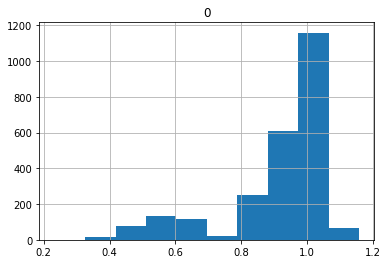

In [244]:
pd.DataFrame(y_pred).hist()

0.893041597544
0.822584329877
[[ 0.06938776  0.01591837]
 [ 0.15387755  0.76081633]]


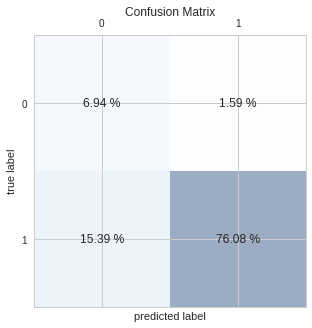

In [317]:
print(roc_auc_score(y_test, y_pred))
threshold = 0.87
y_pred_cut = np.ceil(y_pred-threshold)
print(roc_auc_score(y_test, y_pred_cut))
cm_strat = confusion_matrix(y_test, y_pred_cut).astype(float)/len(y_test)
print(cm_strat)
plot_confusion_matrix(cm_strat)

In [316]:
def plot_confusion_matrix(confmat):
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.4)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i,
            s=("%.2f %%" % float(confmat[i, j]*100)),
            va='center', ha='center')
    plt.xlabel('predicted label')
    plt.ylabel('true label')
    plt.title('Confusion Matrix')
    plt.show()

In [268]:
def plot_roc_curve(y_real, y_pred):
    # Data to compute the ROC curve (FPR and TPR):
    fpr, tpr, thresholds = roc_curve(y_real, y_pred)
    # The Area Under the ROC curve:
    roc_auc = roc_auc_score(y_real, y_pred)
    print(y_real.shape)
    print(y_pred.shape)

    # Plot ROC Curve
    plt.figure(figsize=(8,6))
    lw = 2
    skplt.metrics.plot_roc_curve(y_real, y_pred)
    #plt.plot(fpr, tpr, color='orange', lw=lw, label='ROC curve (AUROC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='random')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.grid()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [338]:
def print_roc_auc(y_true, y_pred):
    """
    y_pred must be the predict_proba
    """
    fpr_rt, tpr_rt, threshold = roc_curve(y_true, y_pred)
    plt.subplots(figsize = (20, 10))
    sns.set_style("whitegrid")

    plt.plot(fpr_rt, tpr_rt, label='RT + LR')
    #plt.plot(fpr_rt, threshold, markeredgecolor='r',linestyle='dashed', color='r')
    #plt.plot(threshold,tpr_rt, markeredgecolor='r',linestyle='dashed', color='g')

    plt.xlabel('FPR',size = 30)
    plt.ylabel('TPR', size = 30)
    plt.title('ROC Curve')
    return plt.show()

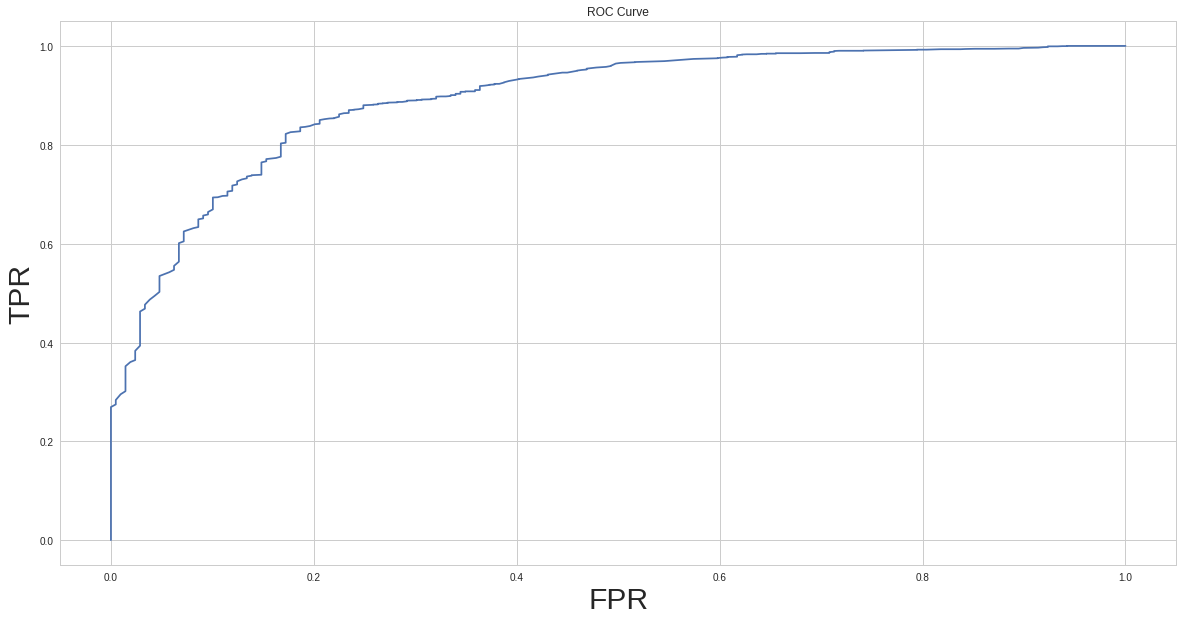

In [339]:
print_roc_auc(y_test, y_pred)

In [336]:
def plot_roc_auc_threshold(y_true, y_pred):
    """
    y_pred must be the predict_proba
    """
    fpr_rt, tpr_rt, threshold = roc_curve(y_true, y_pred)
    plt.subplots(figsize = (20, 10))
    sns.set_style("whitegrid")

    #plt.plot(fpr_rt, tpr_rt, label='RT + LR')
    plt.plot(threshold,fpr_rt, markeredgecolor='r',linestyle='dashed', color='r')
    plt.plot(threshold, tpr_rt, markeredgecolor='r',linestyle='dashed', color='g')
    plt.plot(threshold, tpr_rt - fpr_rt, markeredgecolor='r',linestyle='dashed', color='b')
    plt.plot((0.87, 0.87), (0, 1), 'k-')

    plt.xlabel('Threshold',size = 20)
    plt.ylabel('Ratio', size = 20)
    plt.title('Ratios against threshold')
    plt.legend(['FPR','TPR', 'TPR-FPR', 'Threshold=0.87'],fontsize = 'large')
    return plt.show()

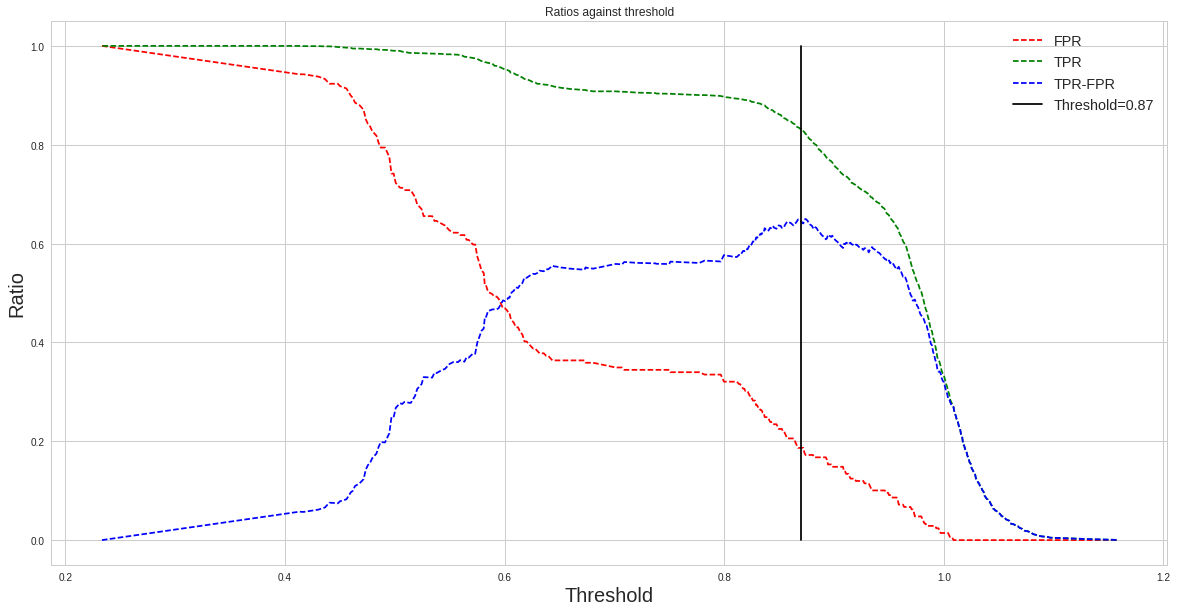

In [337]:
plot_roc_auc_threshold(y_test, y_pred)